In [129]:
import pandas as pd
import numpy as np
import rdkit
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, MACCSkeys
from rdkit.Chem import MACCSkeys
from rdkit.Chem import PandasTools, AllChem
from rdkit import Chem, DataStructs
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor, LazyClassifier
from rdkit.Chem import PandasTools, AllChem
from rdkit import Chem, DataStructs

# Data preprocessing

In [130]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tau_kinase_inhib.csv', delimiter=';', usecols=[7,8,9,10])
df

,Smiles,Standard Type,Standard Relation,Standard Value
0,CCCC(=O)Nc1n[nH]c2cc(-c3cccnc3)ccc12,IC50,'=',10892.00
1,CCCC(=O)Nc1n[nH]c2cc(-c3ccc4c(c3)COO4)ccc12,IC50,'=',25038.00
2,CCCC(=O)Nc1n[nH]c2cc(-c3ccc([N+](=O)[O-])cc3)c...,IC50,'>',100000.00
3,O=c1sn(Cc2ccccc2)c(=S)n1Cc1ccccc1,IC50,'=',10000.00
4,CC(C)c1cc(NCc2cccnc2)n2ncc(Br)c2n1,IC50,'=',420.00
...,...,...,...,...
3184,O=c1cc(-c2ccc(O)c(O)c2)oc2cc(O)c([C@@H]3O[C@H]...,IC50,'=',185000.00
3185,COc1ccc(-c2cc(=O)c3c(OC)c([C@@H]4O[C@H](C(=O)N...,IC50,'=',9000.00
3186,O=C1NC(=O)/C(=C/c2c[nH]c3ccccc23)S1,IC50,'=',4930.00
3187,C=CC(=O)N1C(=O)CC(c2ccc(Br)cc2)Sc2ccccc21,IC50,'=',6400.00


In [131]:
df2 = df[df['Standard Relation'].str.contains('=')== True ]
df2

,Smiles,Standard Type,Standard Relation,Standard Value
0,CCCC(=O)Nc1n[nH]c2cc(-c3cccnc3)ccc12,IC50,'=',10892.00
1,CCCC(=O)Nc1n[nH]c2cc(-c3ccc4c(c3)COO4)ccc12,IC50,'=',25038.00
3,O=c1sn(Cc2ccccc2)c(=S)n1Cc1ccccc1,IC50,'=',10000.00
4,CC(C)c1cc(NCc2cccnc2)n2ncc(Br)c2n1,IC50,'=',420.00
6,COc1cccc(-n2ncc3c(N/N=C/c4ccc(NC(C)=O)cc4)ncnc...,IC50,'=',12.59
...,...,...,...,...
3184,O=c1cc(-c2ccc(O)c(O)c2)oc2cc(O)c([C@@H]3O[C@H]...,IC50,'=',185000.00
3185,COc1ccc(-c2cc(=O)c3c(OC)c([C@@H]4O[C@H](C(=O)N...,IC50,'=',9000.00
3186,O=C1NC(=O)/C(=C/c2c[nH]c3ccccc23)S1,IC50,'=',4930.00
3187,C=CC(=O)N1C(=O)CC(c2ccc(Br)cc2)Sc2ccccc21,IC50,'=',6400.00


In [132]:
df2.rename(columns={'Standard Value':'IC50'}, inplace=True)

In [133]:
repeated_smiles = df2[df2.Smiles.duplicated()].Smiles.unique()

In [134]:
for smi in repeated_smiles:
  df_temp = df2[df2.Smiles==smi]
  df2.loc[df2.Smiles==smi, 'IC50'] = df_temp.IC50.median()

In [135]:
df2.drop_duplicates(subset=['Smiles', 'IC50'], inplace=True)
df2.shape

(2214, 4)

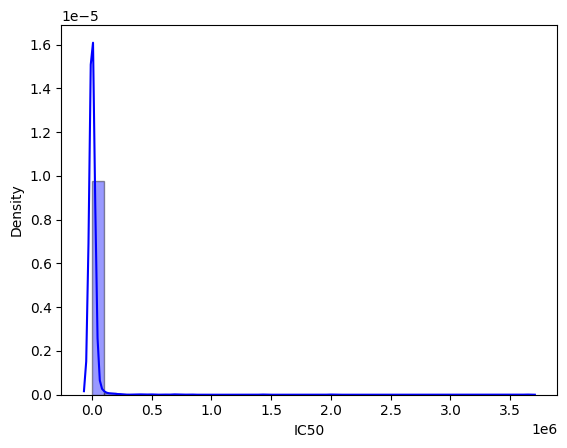

In [136]:
sns.distplot(df2['IC50'], hist=True, kde=True,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.show()

In [137]:
df2['lgIC50'] = df2.IC50.apply(np.log10)

In [138]:
df2.lgIC50.mean()

2.376340849616336

In [139]:
def detect_outliers_zscore(data, threshold=3.0):
    """
    Detect outliers using Z-score method.

    Parameters:
        data (array-like): Input data.
        threshold (float): Z-score threshold for identifying outliers.

    Returns:
        outliers (array-like): Array containing the indices of outlier data points.
    """
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = [(x - mean) / std_dev for x in data]
    outliers = np.where(np.abs(z_scores) > threshold)[0]
    return outliers

# Example usage:
outliers = detect_outliers_zscore(df2['lgIC50'])
print("Indices of outliers:", outliers)
print("Outlier values:", [df2['lgIC50'].iloc[i] for i in outliers])

Indices of outliers: [ 51 415 813]
Outlier values: [6.561101383649056, 6.301029995663981, -1.8860566476931633]


In [140]:
filtered_data = df2.drop(df2.index[outliers], errors='ignore')
filtered_data

,Smiles,Standard Type,Standard Relation,IC50,lgIC50
0,CCCC(=O)Nc1n[nH]c2cc(-c3cccnc3)ccc12,IC50,'=',8396.00,3.92
1,CCCC(=O)Nc1n[nH]c2cc(-c3ccc4c(c3)COO4)ccc12,IC50,'=',25038.00,4.40
3,O=c1sn(Cc2ccccc2)c(=S)n1Cc1ccccc1,IC50,'=',10000.00,4.00
4,CC(C)c1cc(NCc2cccnc2)n2ncc(Br)c2n1,IC50,'=',420.00,2.62
6,COc1cccc(-n2ncc3c(N/N=C/c4ccc(NC(C)=O)cc4)ncnc...,IC50,'=',12.59,1.10
...,...,...,...,...,...
3182,CN(c1ncnc2[nH]c3cc(Cl)ccc3c12)C1CCCN(C(=O)CC#N)C1,IC50,'=',2000.00,3.30
3184,O=c1cc(-c2ccc(O)c(O)c2)oc2cc(O)c([C@@H]3O[C@H]...,IC50,'=',185000.00,5.27
3185,COc1ccc(-c2cc(=O)c3c(OC)c([C@@H]4O[C@H](C(=O)N...,IC50,'=',9000.00,3.95
3187,C=CC(=O)N1C(=O)CC(c2ccc(Br)cc2)Sc2ccccc21,IC50,'=',6400.00,3.81


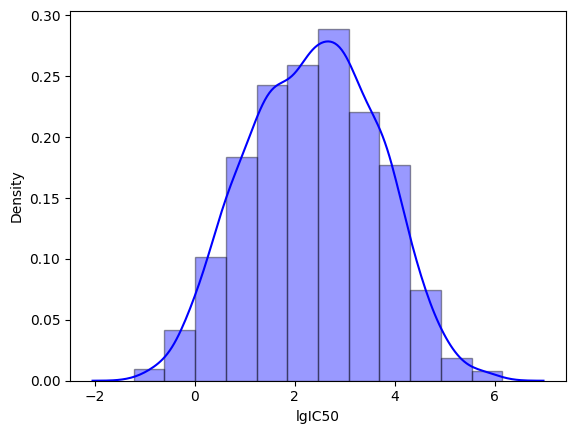

In [141]:
sns.distplot(filtered_data['lgIC50'], hist=True, kde=True,
             bins=int(180/15), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.show()

In [142]:
filtered_data['Class'] = (filtered_data['lgIC50'] > 2.4).astype(int) # based on median value

In [143]:
X_train, X_test, y_train, y_test = train_test_split(filtered_data['Smiles'], filtered_data['lgIC50'], test_size=0.2, random_state=42)

# Different representations

In [144]:
class MolecularDescriptorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, descriptor_type='standard'):
        self.descriptor_type = descriptor_type
        self.descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
        self.get_descriptors = rdMolDescriptors.Properties(self.descriptor_names)

    def smi_to_descriptors(self, smile):
        mol = Chem.MolFromSmiles(smile)
        if mol:
            descriptors = np.array(self.get_descriptors.ComputeProperties(mol))
            return descriptors
        else:
            return np.zeros(len(self.descriptor_names))

    def smi_to_MACCS(self, smile):
        mol = Chem.MolFromSmiles(smile)
        if mol:
            maccs = np.array(list(MACCSkeys.GenMACCSKeys(mol).ToBitString())).astype(int)
            return maccs
        else:
            return np.zeros(167)

    def smi_to_Morgan(self, smile):
        mol = Chem.MolFromSmiles(smile)
        if mol:
            fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=512)
            ar = np.zeros((1,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp, ar)
            return ar
        else:
            return np.zeros(2048)


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.descriptor_type == 'standard':
            return np.vstack(X.apply(self.smi_to_descriptors))
        elif self.descriptor_type == 'MACCS':
            return np.vstack(X.apply(self.smi_to_MACCS))
        elif self.descriptor_type == 'Morgan':
            return np.vstack(X.apply(self.smi_to_Morgan))
        else:
            raise ValueError("Unsupported descriptor type")

In [145]:
descriptor_pipeline = Pipeline([
    ('descriptors', MolecularDescriptorTransformer(descriptor_type='standard')),
    ('scaler', StandardScaler())
])

X_train_transformed = descriptor_pipeline.fit_transform(X_train)
X_test_transformed = descriptor_pipeline.transform(X_test)

In [146]:
maccs_pipeline = Pipeline([
    ('MACCS', MolecularDescriptorTransformer(descriptor_type='MACCS')),
    ('scaler', StandardScaler())
])

X_train_maccs = maccs_pipeline.fit_transform(X_train)
X_test_maccs = maccs_pipeline.transform(X_test)

In [147]:
Morgan_pipeline = Pipeline([
    ('Morgan', MolecularDescriptorTransformer(descriptor_type='Morgan')),
    ('scaler', StandardScaler())
])

X_train_morgan = maccs_pipeline.fit_transform(X_train)
X_test_morgan = maccs_pipeline.transform(X_test)

# Regression

In [74]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, random_state=42)
models, predictions = reg.fit(X_train_transformed, X_test_transformed, y_train, y_test)
print("Results for RDKit descriptors:")
print(models)

 98%|█████████▊| 40/41 [00:17<00:00,  2.10it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5770
[LightGBM] [Info] Number of data points in the train set: 1768, number of used features: 43
[LightGBM] [Info] Start training from score 2.360468


100%|██████████| 41/41 [00:18<00:00,  2.25it/s]

Results for RDKit descriptors:
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                        0.48       0.53  0.90        4.49
ExtraTreesRegressor                          0.48       0.53  0.90        1.38
LGBMRegressor                                0.45       0.50  0.93        0.28
HistGradientBoostingRegressor                0.45       0.50  0.93        0.63
BaggingRegressor                             0.41       0.47  0.96        0.52
GradientBoostingRegressor                    0.38       0.44  0.98        1.33
XGBRegressor                                 0.38       0.44  0.99        0.67
KNeighborsRegressor                          0.37       0.43  0.99        0.02
NuSVR                                        0.36       0.42  1.00        0.25
SVR                                          0.35       0.42  1.00        0.50
MLPRegressor         

In [76]:
reg_maccs = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, random_state=10)
models_maccs, predictions_maccs = reg_maccs.fit(X_train_maccs, X_test_maccs, y_train, y_test)
print("Results for MACCS descriptors:")
print(models_maccs)

100%|██████████| 41/41 [00:26<00:00,  1.52it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 1768, number of used features: 135
[LightGBM] [Info] Start training from score 2.360468
Results for MACCS descriptors:
                                          Adjusted R-Squared  \
Model                                                          
RandomForestRegressor                                   0.31   
BaggingRegressor                                        0.27   
XGBRegressor                                            0.26   
HistGradientBoostingRegressor                           0.26   
LGBMRegressor                                           0.24   
SVR                                                     0.19   
NuSVR                                               

In [77]:
reg_morgan = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, random_state=10)
models_morgan, predictions_morgan = reg_morgan.fit(X_train_morgan, X_test_morgan, y_train, y_test)
print("Results for MACCS descriptors:")
print(models_morgan)

100%|██████████| 41/41 [00:28<00:00,  1.44it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 1768, number of used features: 135
[LightGBM] [Info] Start training from score 2.360468
Results for MACCS descriptors:
                                          Adjusted R-Squared  \
Model                                                          
RandomForestRegressor                                   0.31   
BaggingRegressor                                        0.27   
XGBRegressor                                            0.26   
HistGradientBoostingRegressor                           0.26   
LGBMRegressor                                           0.24   
SVR                                                     0.19   
NuSVR                                               

### Random Forest Regressor (Morgan fingerprints)

In [80]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [83]:
pip install optuna_integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 2.8 MB/s eta 0:00:00


In [81]:
from sklearn.ensemble import RandomForestRegressor
import optuna

In [94]:
param_distrs = {
        "n_estimators": optuna.distributions.IntDistribution(50, 300),
        "max_depth": optuna.distributions.IntDistribution(2, 20),
        "min_samples_split": optuna.distributions.IntDistribution(2, 10),
        "min_samples_leaf": optuna.distributions.IntDistribution(1, 10)
    }
rf = RandomForestRegressor(random_state=42)
opt_search = optuna.integration.OptunaSearchCV(rf, param_distrs, cv = 5,
                                                n_trials=50, scoring='neg_root_mean_squared_error')

In [95]:
opt_search.fit(X_train_morgan, y_train)

[I 2024-10-01 16:46:32,014] A new study created in memory with name: no-name-4723fb44-e1bc-4079-a91f-6fc82ff127f4
[I 2024-10-01 16:46:38,235] Trial 0 finished with value: -0.8614932041995242 and parameters: {'n_estimators': 136, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 0 with value: -0.8614932041995242.
[I 2024-10-01 16:46:43,358] Trial 1 finished with value: -1.0286417412792885 and parameters: {'n_estimators': 163, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: -0.8614932041995242.
[I 2024-10-01 16:46:53,478] Trial 2 finished with value: -0.8781750216684913 and parameters: {'n_estimators': 226, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 0 with value: -0.8614932041995242.
[I 2024-10-01 16:47:08,964] Trial 3 finished with value: -0.826144137171644 and parameters: {'n_estimators': 266, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 3 with 

OptunaSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=1,
               n_trials=50,
               param_distributions={'max_depth': IntDistribution(high=20, log=False, low=2, step=1),
                                    'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1),
                                    'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1),
                                    'n_estimators': IntDistribution(high=300, log=False, low=50, step=1)},
               scoring='neg_root_mean_squared_error')

In [96]:
print('Best hyperparameters:', opt_search.best_params_)
print('Best RMSE:', opt_search.best_score_)

Best hyperparameters: {'n_estimators': 237, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1}
Best RMSE: -0.796699836571739


In [92]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, balanced_accuracy_score, precision_score

In [97]:
best_params = {'n_estimators': 73, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 1}
model = RandomForestRegressor(random_state=42, **best_params)
model.fit(X_train_morgan, y_train)
y_pred_test = model.predict(X_test_morgan)
y_pred_train = model.predict(X_train_morgan)
print('train r2', r2_score(y_train, y_pred_train))
print('train rmse', mean_squared_error(y_train, y_pred_train, squared=False))
print('test r2', r2_score(y_test, y_pred_test))
print('test rmse', mean_squared_error(y_test, y_pred_test, squared=False))

train r2 0.8906774793438779
train rmse 0.421310526492007
test r2 0.555762409283895
test rmse 0.8761695169967421


## Classification task (treshold = 2.4)

In [148]:
X_train, X_test, y_train_clf, y_test_clf = train_test_split(filtered_data['Smiles'], filtered_data['Class'], test_size=0.2, random_state=42)

In [149]:
clf1 = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, random_state=42)
models, predictions = clf1.fit(X_train_transformed, X_test_transformed, y_train_clf, y_test_clf)
print("Results for RDKit descriptors:")
print(models)

100%|██████████| 29/29 [00:08<00:00,  3.34it/s]

Results for RDKit descriptors:
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.77               0.77     0.77      0.77   
BaggingClassifier                  0.77               0.77     0.77      0.77   
RandomForestClassifier             0.77               0.77     0.77      0.77   
NuSVC                              0.76               0.76     0.76      0.76   
XGBClassifier                      0.76               0.76     0.76      0.76   
SVC                                0.75               0.75     0.75      0.75   
LGBMClassifier                     0.75               0.75     0.75      0.75   
LabelPropagation                   0.74               0.74     0.74      0.74   
LabelSpreading                     0.74               0.74     0.74      0.74   
KNeighborsClassifier               0.73               0.74     0.74      0.73 

In [105]:
clf2 = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, random_state=42)
models, predictions = clf2.fit(X_train_maccs, X_test_maccs, y_train_clf, y_test_clf)
print("Results for MACCS descriptors:")
print(models)

100%|██████████| 29/29 [00:10<00:00,  2.85it/s]

[LightGBM] [Info] Number of positive: 867, number of negative: 901
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 1768, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490385 -> initscore=-0.038466
[LightGBM] [Info] Start training from score -0.038466
Results for MACCS descriptors:
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.81               0.81     0.81      0.81   
RandomForestClassifier             0.81               0.81     0.81      0.81   
ExtraTreesClassifier               0.80               0.81     0.81      0.80   
XGBClassifi

In [106]:
clf3 = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, random_state=42)
models, predictions = clf3.fit(X_train_morgan, X_test_morgan, y_train_clf, y_test_clf)
print("Results for Morgan fingerprints:")
print(models)

100%|██████████| 29/29 [00:09<00:00,  2.94it/s]

[LightGBM] [Info] Number of positive: 867, number of negative: 901
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 1768, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490385 -> initscore=-0.038466
[LightGBM] [Info] Start training from score -0.038466
Results for Morgan fingerprints:
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.81               0.81     0.81      0.81   
RandomForestClassifier             0.81               0.81     0.81      0.81   
ExtraTreesClassifier               0.80               0.81     0.81      0.80   
XGBClassi

# LGBM Classifier

In [150]:
import lightgbm as lgb

In [109]:
param_distrs = {
        "n_estimators": optuna.distributions.IntDistribution(100, 1000),
        "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
        "num_leaves": optuna.distributions.IntDistribution(2, 2**10),
        "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
        "colsample_bytree": optuna.distributions.FloatDistribution(0.05, 1.0),
        "min_data_in_leaf": optuna.distributions.IntDistribution(1, 10),
    }
lgbm = lgb.LGBMClassifier(random_state=42, verbose=-1)
opt_search = optuna.integration.OptunaSearchCV(lgbm, param_distrs, cv = 5,
                                                n_trials=50, scoring='accuracy')

In [110]:
opt_search.fit(X_train_maccs, y_train_clf)

[I 2024-10-01 17:08:45,399] A new study created in memory with name: no-name-332eebd3-9926-4f79-b907-e907678a4ee0
[I 2024-10-01 17:08:49,687] Trial 0 finished with value: 0.7969606760455179 and parameters: {'n_estimators': 274, 'learning_rate': 0.0054520427220232795, 'num_leaves': 998, 'subsample': 0.20685782141382902, 'colsample_bytree': 0.2727750476731654, 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.7969606760455179.
[I 2024-10-01 17:09:00,659] Trial 1 finished with value: 0.78621981082249 and parameters: {'n_estimators': 599, 'learning_rate': 0.001360849701218101, 'num_leaves': 894, 'subsample': 0.16103372561959886, 'colsample_bytree': 0.14849007393561572, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7969606760455179.
[I 2024-10-01 17:09:06,544] Trial 2 finished with value: 0.7947007890398681 and parameters: {'n_estimators': 987, 'learning_rate': 0.036731721743948266, 'num_leaves': 39, 'subsample': 0.21304957299419613, 'colsample_bytree': 0.6272213732548987, 'min_

OptunaSearchCV(cv=5, estimator=LGBMClassifier(random_state=42, verbose=-1),
               n_jobs=1, n_trials=50,
               param_distributions={'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.05, step=None),
                                    'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None),
                                    'min_data_in_leaf': IntDistribution(high=10, log=False, low=1, step=1),
                                    'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1),
                                    'num_leaves': IntDistribution(high=1024, log=False, low=2, step=1),
                                    'subsample': FloatDistribution(high=1.0, log=False, low=0.05, step=None)},
               scoring='accuracy')

In [111]:
print('Best hyperparameters:', opt_search.best_params_)
print('Best accuracy:', opt_search.best_score_)

Best hyperparameters: {'n_estimators': 470, 'learning_rate': 0.004973780588086577, 'num_leaves': 339, 'subsample': 0.9965100054800088, 'colsample_bytree': 0.6451036281965211, 'min_data_in_leaf': 7}
Best accuracy: 0.8048766825114834


In [206]:
best_params = {'n_estimators': 460, 'learning_rate': 0.00477194086869811, 'num_leaves': 512, 'subsample': 0.27387696809428136, 'colsample_bytree': 0.393370848862446, 'min_data_in_leaf': 6}
model = lgb.LGBMClassifier(**best_params, random_state=42, verbose=-1)
model.fit(X_train_maccs, y_train_clf)
y_pred_test = model.predict(X_test_maccs)
y_pred_train = model.predict(X_train_maccs)
print('train accuracy', accuracy_score(y_train_clf, y_pred_train))
print('train F1', f1_score(y_train_clf, y_pred_train))
print('test accuracy', accuracy_score(y_test_clf, y_pred_test))
print('test f1', f1_score(y_test_clf, y_pred_test))

train accuracy 0.9502262443438914
train F1 0.9488966318234612
test accuracy 0.8103837471783296
test f1 0.8197424892703862


# Fandom Forest Classifier

In [152]:
from sklearn.ensemble import RandomForestClassifier
param_distrs = {
        "n_estimators": optuna.distributions.IntDistribution(100, 1000),
        "max_depth": optuna.distributions.IntDistribution(2, 50),
        "min_samples_split": optuna.distributions.IntDistribution(2, 10),
        "min_samples_leaf": optuna.distributions.IntDistribution(1, 10)
    }
rf_clf = RandomForestClassifier(random_state=42)
opt_search = optuna.integration.OptunaSearchCV(rf_clf, param_distrs, cv = 5,
                                                n_trials=50, scoring='accuracy')

In [114]:
opt_search.fit(X_train_maccs, y_train_clf)

[I 2024-10-01 17:18:08,439] A new study created in memory with name: no-name-b167a059-1407-4fae-a467-f38d7131e1a5
[I 2024-10-01 17:18:13,035] Trial 0 finished with value: 0.7805668923352698 and parameters: {'n_estimators': 341, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7805668923352698.
[I 2024-10-01 17:18:21,333] Trial 1 finished with value: 0.7890510715257439 and parameters: {'n_estimators': 549, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7890510715257439.
[I 2024-10-01 17:18:26,857] Trial 2 finished with value: 0.7550983498983691 and parameters: {'n_estimators': 530, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7890510715257439.
[I 2024-10-01 17:18:40,504] Trial 3 finished with value: 0.7890526720122917 and parameters: {'n_estimators': 944, 'max_depth': 36, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 3 with value:

OptunaSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
               n_jobs=1, n_trials=50,
               param_distributions={'max_depth': IntDistribution(high=50, log=False, low=2, step=1),
                                    'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1),
                                    'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1),
                                    'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1)},
               scoring='accuracy')

In [115]:
print('Best hyperparameters:', opt_search.best_params_)
print('Best accuracy:', opt_search.best_score_)

Best hyperparameters: {'n_estimators': 519, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 1}
Best accuracy: 0.8020534242409691


In [160]:
best_params = {'n_estimators': 519, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 1}
model = RandomForestClassifier(random_state=42, **best_params)
model.fit(X_train_maccs, y_train_clf)
y_pred_test = model.predict(X_test_maccs)
y_pred_train = model.predict(X_train_maccs)
print('train accuracy', accuracy_score(y_train_clf, y_pred_train))
print('train F1', f1_score(y_train_clf, y_pred_train))
print('test accuracy', accuracy_score(y_test_clf, y_pred_test))
print('test f1', f1_score(y_test_clf, y_pred_test))

train accuracy 0.9604072398190046
train F1 0.9592074592074592
test accuracy 0.8216704288939052
test f1 0.8293736501079915


# Extra Trees Classifier (final model)

In [154]:
from sklearn.ensemble import ExtraTreesClassifier

param_distrs = {
        "n_estimators": optuna.distributions.IntDistribution(100, 1000),
        "max_depth": optuna.distributions.IntDistribution(2, 50),
        "min_samples_split": optuna.distributions.IntDistribution(2, 10),
        "min_samples_leaf": optuna.distributions.IntDistribution(1, 10),
        "criterion": optuna.distributions.CategoricalDistribution(['gini', 'entropy'])
    }
et = ExtraTreesClassifier(random_state=42)
opt_search = optuna.integration.OptunaSearchCV(et, param_distrs, cv = 5,
                                                n_trials=50, scoring='f1')

In [124]:
opt_search.fit(X_train_maccs, y_train_clf)

[I 2024-10-01 17:33:17,404] A new study created in memory with name: no-name-97898678-4d76-498e-9b54-bc596a31c189
[I 2024-10-01 17:33:23,202] Trial 0 finished with value: 0.7722541819668022 and parameters: {'n_estimators': 413, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7722541819668022.
[I 2024-10-01 17:33:35,568] Trial 1 finished with value: 0.7718892912921119 and parameters: {'n_estimators': 1000, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7722541819668022.
[I 2024-10-01 17:33:43,777] Trial 2 finished with value: 0.7698136069051686 and parameters: {'n_estimators': 585, 'max_depth': 42, 'min_samples_split': 7, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 0 with value: 0.7722541819668022.
[I 2024-10-01 17:33:52,806] Trial 3 finished with value: 0.7640446945948774 and parameters: {'n_estimators': 747, 'max_depth': 13, 'mi

OptunaSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42), n_jobs=1,
               n_trials=50,
               param_distributions={'criterion': CategoricalDistribution(choices=('gini', 'entropy')),
                                    'max_depth': IntDistribution(high=50, log=False, low=2, step=1),
                                    'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1),
                                    'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1),
                                    'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1)},
               scoring='f1')

In [125]:
print('Best hyperparameters:', opt_search.best_params_)
print('Best accuracy:', opt_search.best_score_)

Best hyperparameters: {'n_estimators': 686, 'max_depth': 44, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Best accuracy: 0.7935143675515491


In [208]:
best_params = {'n_estimators': 376, 'max_depth': 38, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'} # {'n_estimators': 376, 'max_depth': 38, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}
model = ExtraTreesClassifier(**best_params, random_state=42)
model.fit(X_train_maccs, y_train_clf)
y_pred_test = model.predict(X_test_maccs)
y_pred_train = model.predict(X_train_maccs)
print('train accuracy', accuracy_score(y_train_clf, y_pred_train))
print('train F1', f1_score(y_train_clf, y_pred_train))
print('test accuracy', accuracy_score(y_test_clf, y_pred_test))
print('test f1', f1_score(y_test_clf, y_pred_test))
print('test precision', precision_score(y_test_clf, y_pred_test))

train accuracy 0.9417420814479638
train F1 0.9399416909620992
test accuracy 0.8216704288939052
test f1 0.8293736501079915
test precision 0.8458149779735683


In [215]:
import pickle

In [222]:
with open('alzheimer_clf.pkl', 'wb') as f:
    pickle.dump(model, f)

### Feature importance

In [162]:
importances = model.feature_importances_

In [165]:
feature_names = [f'bit{i}' for i in range(X_train_maccs.shape[1])]
df = pd.DataFrame(X_train_maccs, columns=feature_names)

In [167]:
importance_df = pd.DataFrame({'Feature': df.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [168]:
print(importance_df)

    Feature  Importance
144  bit144        0.02
62    bit62        0.02
97    bit97        0.02
65    bit65        0.02
36    bit36        0.01
..      ...         ...
15    bit15        0.00
20    bit20        0.00
30    bit30        0.00
31    bit31        0.00
0      bit0        0.00

[167 rows x 2 columns]


In [196]:
filtered_importance_df = importance_df[importance_df['Importance'] > 0.01].sort_values(by='Importance', ascending=False)

In [197]:
filtered_importance_df.index

Index([144,  62,  97,  65,  36, 105, 101, 142,  83, 150,  79,  96,  80, 155,
        90,  57, 136,  38, 131, 147,  50,  92,  91,  81,  93, 159, 152, 145,
       134,  87, 160, 146],
      dtype='int64')

In [181]:
X_train_maccs = pd.DataFrame(X_train_maccs)

In [187]:
X_train_maccs_reduced = df.iloc[:, [44, 62, 97,  65,  36, 105, 101, 142,  83, 150,  79,  96,  80, 155, 90,  57, 136,  38, 131, 147,  50,  92,  91,  81,  93, 159, 152, 145, 134,  87, 160, 146]]

In [189]:
X_test_maccs_reduced = pd.DataFrame(X_test_maccs).iloc[:, [44, 62, 97,  65,  36, 105, 101, 142,  83, 150,  79,  96,  80, 155, 90,  57, 136,  38, 131, 147,  50,  92,  91,  81,  93, 159, 152, 145, 134,  87, 160, 146]]

In [193]:
best_params = {'n_estimators': 686, 'max_depth': 44, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'entropy'}
model2 = ExtraTreesClassifier(**best_params, random_state=42)
model2.fit(X_train_maccs_reduced, y_train_clf)
y_pred_test = model2.predict(X_test_maccs_reduced)
y_pred_train = model2.predict(X_train_maccs_reduced)
print('train accuracy', accuracy_score(y_train_clf, y_pred_train))
print('train F1', f1_score(y_train_clf, y_pred_train))
print('test accuracy', accuracy_score(y_test_clf, y_pred_test))
print('test f1', f1_score(y_test_clf, y_pred_test))
print('test precision', precision_score(y_test_clf, y_pred_test))

train accuracy 0.9377828054298643
train F1 0.9358226371061844
test accuracy 0.7697516930022573
test f1 0.7811158798283262
test precision 0.7913043478260869
